In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import mlflow
from lib.config import AppConfig
from experiment_analysis.experiment_data_utils import get_full_runs_df
from IPython.display import display, HTML
from pathlib import Path

import pandas as pd


config = AppConfig()
mlflow.set_tracking_uri(config.mlflow_tracking_uri)

In [115]:
runs = get_full_runs_df(config.optimization_experiment_results_path)

In [116]:
len(runs)

16023

In [117]:
filtered_runs = runs[~runs["params.model_type"].isna()]  # Remove runs without model type (parent runs)
filtered_runs["params.oxide"].value_counts()

model_type_counts = filtered_runs.groupby("params.oxide")["params.model_type"].value_counts().unstack(fill_value=0)
model_type_counts['Total'] = model_type_counts.sum(axis=1)
model_type_counts.loc['Total'] = model_type_counts.sum(axis=0)
display(model_type_counts)


params.model_type,elasticnet,extra_trees,gbr,lasso,ngboost,pls,random_forest,ridge,svr,xgboost,Total
params.oxide,,,,,,,,,,,
Al2O3,200,200,200,200,200,200,200,200,200,200,2000
CaO,200,200,200,200,200,200,200,200,200,200,2000
FeOT,200,200,200,200,200,200,200,200,200,200,2000
K2O,200,200,200,200,200,200,200,200,200,200,2000
MgO,200,200,200,200,143,200,200,200,200,200,1943
Na2O,200,200,200,200,200,200,200,200,200,200,2000
SiO2,200,200,200,200,200,200,200,200,200,200,2000
TiO2,200,200,200,200,200,200,200,200,200,200,2000
Total,1600,1600,1600,1600,1543,1600,1600,1600,1600,1600,15943


In [118]:
from lib.reproduction import major_oxides

analysis_target = "SiO2"
n_splits=4
assert analysis_target in major_oxides, f"{analysis_target} is not a valid oxide. Please choose from {major_oxides}"

In [119]:
from experiment_analysis.experiment_data_utils import clean_experiment_data

filtered_runs = clean_experiment_data(runs)

num_filtered_out = len(filtered_runs) - len(filtered_runs[filtered_runs['metrics.rmse_cv'] <= 50])
filtered_runs = filtered_runs[filtered_runs['metrics.rmse_cv'] <= 50]
print(f"Number of runs filtered out: {num_filtered_out}")
total_runs = len(runs)
total_filtered_runs = len(filtered_runs)

print(f"Total runs: {total_runs}")
print(f"Total filtered runs: {total_filtered_runs}")
print(f"Difference (Total runs - Total filtered runs): {total_runs - total_filtered_runs}")

Number of runs filtered out: 221
Total runs: 16023
Total filtered runs: 15245
Difference (Total runs - Total filtered runs): 778


In [120]:
filtered_runs["params.oxide"].value_counts()

params.oxide
Al2O3    1943
FeOT     1928
SiO2     1926
CaO      1903
TiO2     1892
Na2O     1891
K2O      1883
MgO      1879
Name: count, dtype: int64

In [121]:
def display_table_with_options(df, max_columns=10, max_rows=100, display_func=lambda x: display(x)):
    original_max_columns = pd.get_option('display.max_columns')
    original_max_rows = pd.get_option('display.max_rows')

    pd.set_option('display.max_columns', max_columns)
    pd.set_option('display.max_rows', max_rows)

    display_func(df)

    pd.set_option('display.max_columns', original_max_columns)
    pd.set_option('display.max_rows', original_max_rows)

# Multivariate

In [122]:
overview_list = []
for oxide in major_oxides:
    overview_df = filtered_runs[["params.oxide", "params.model_type", "params.transformer_type", "params.pca_type", "params.scaler_type", "metrics.rmse_cv", "metrics.std_dev_cv", "metrics.rmse"]]

    overview_df = overview_df[overview_df['params.oxide'] == oxide].sort_values(by='metrics.rmse_cv')
    unique_model_types_df = overview_df.drop_duplicates(subset=['params.model_type'])
    overview_list.append(unique_model_types_df)

for oxide, df in zip(major_oxides, overview_list):
    display(HTML(f"<h2>{oxide}</h2>"))
    display_table_with_options(df, max_columns=10, max_rows=100)


,params.oxide,params.model_type,params.transformer_type,params.pca_type,params.scaler_type,metrics.rmse_cv,metrics.std_dev_cv,metrics.rmse
1213,SiO2,pls,none,kernel_pca,min_max_scaler,4.552021,4.551431,4.084362
1687,SiO2,svr,none,none,min_max_scaler,4.591604,4.588081,3.532896
1817,SiO2,gbr,none,none,norm3_scaler,4.651792,4.646464,3.719811
628,SiO2,lasso,power_transformer,pca,norm3_scaler,4.736667,4.738305,4.248299
1034,SiO2,xgboost,quantile_transformer,none,norm3_scaler,4.791000,4.781044,3.968061
239,SiO2,elasticnet,quantile_transformer,none,norm3_scaler,4.841359,4.843702,3.947116
808,SiO2,ngboost,power_transformer,none,norm3_scaler,4.859746,4.850966,4.147967
489,SiO2,ridge,power_transformer,none,norm3_scaler,4.940480,4.938138,3.815540
1415,SiO2,extra_trees,power_transformer,none,norm3_scaler,5.141448,5.118042,3.820783
73,SiO2,random_forest,none,none,norm3_scaler,5.203819,5.191888,3.787589


,params.oxide,params.model_type,params.transformer_type,params.pca_type,params.scaler_type,metrics.rmse_cv,metrics.std_dev_cv,metrics.rmse
3762,TiO2,svr,power_transformer,none,norm3_scaler,0.408701,0.406385,0.397053
3869,TiO2,gbr,power_transformer,none,norm3_scaler,0.409730,0.408748,0.332471
3145,TiO2,xgboost,none,none,robust_scaler,0.410616,0.410370,0.316572
2184,TiO2,random_forest,quantile_transformer,none,norm3_scaler,0.422384,0.420629,0.334133
2470,TiO2,elasticnet,none,none,robust_scaler,0.423295,0.423306,0.351309
3417,TiO2,extra_trees,power_transformer,none,standard_scaler,0.425908,0.426013,0.337645
2668,TiO2,ridge,none,none,min_max_scaler,0.427579,0.426859,0.359166
2922,TiO2,lasso,power_transformer,none,standard_scaler,0.430815,0.429989,0.372479
2320,TiO2,ngboost,none,none,robust_scaler,0.431336,0.430507,0.355310
3364,TiO2,pls,power_transformer,kernel_pca,robust_scaler,0.440842,0.440607,0.411465


,params.oxide,params.model_type,params.transformer_type,params.pca_type,params.scaler_type,metrics.rmse_cv,metrics.std_dev_cv,metrics.rmse
5062,Al2O3,xgboost,power_transformer,none,norm3_scaler,2.075363,2.067163,1.740205
5843,Al2O3,gbr,power_transformer,none,robust_scaler,2.092107,2.089475,1.986597
4063,Al2O3,ngboost,power_transformer,none,robust_scaler,2.121021,2.112730,2.052195
5646,Al2O3,svr,quantile_transformer,none,min_max_scaler,2.178905,2.176400,1.873075
4707,Al2O3,ridge,quantile_transformer,none,norm3_scaler,2.217908,2.211350,1.843028
4506,Al2O3,elasticnet,quantile_transformer,none,norm3_scaler,2.224726,2.218543,1.804264
5351,Al2O3,pls,quantile_transformer,none,robust_scaler,2.247312,2.243696,2.110514
4852,Al2O3,lasso,quantile_transformer,none,norm3_scaler,2.249181,2.242429,1.903358
5475,Al2O3,extra_trees,power_transformer,none,min_max_scaler,2.288460,2.261357,2.091516
4218,Al2O3,random_forest,power_transformer,none,max_abs_scaler,2.302139,2.295194,2.111017


,params.oxide,params.model_type,params.transformer_type,params.pca_type,params.scaler_type,metrics.rmse_cv,metrics.std_dev_cv,metrics.rmse
7779,FeOT,svr,quantile_transformer,none,norm3_scaler,2.242387,2.243303,1.803171
7388,FeOT,pls,power_transformer,none,standard_scaler,2.701247,2.669157,2.062978
6520,FeOT,ridge,quantile_transformer,none,norm3_scaler,2.707415,2.687497,1.877723
7964,FeOT,gbr,power_transformer,none,max_abs_scaler,2.748689,2.749705,1.793351
7142,FeOT,xgboost,none,none,max_abs_scaler,2.749488,2.743086,1.622473
6248,FeOT,elasticnet,power_transformer,none,max_abs_scaler,2.861748,2.831049,1.773040
6640,FeOT,lasso,quantile_transformer,none,norm3_scaler,2.874875,2.862145,1.842193
7573,FeOT,extra_trees,none,none,max_abs_scaler,2.899789,2.902789,1.869576
6941,FeOT,ngboost,none,none,robust_scaler,2.979960,2.952596,1.772946
6154,FeOT,random_forest,quantile_transformer,none,norm3_scaler,3.079249,3.043626,2.018026


,params.oxide,params.model_type,params.transformer_type,params.pca_type,params.scaler_type,metrics.rmse_cv,metrics.std_dev_cv,metrics.rmse
9614,MgO,svr,power_transformer,none,robust_scaler,1.321517,1.320551,0.791150
9332,MgO,pls,none,kernel_pca,norm3_scaler,1.327285,1.321169,0.993173
8604,MgO,ridge,power_transformer,none,robust_scaler,1.447727,1.443408,1.320890
8387,MgO,elasticnet,power_transformer,none,robust_scaler,1.466054,1.462077,1.630314
9853,MgO,gbr,quantile_transformer,none,norm3_scaler,1.468274,1.464279,0.880105
9398,MgO,extra_trees,power_transformer,none,norm3_scaler,1.533220,1.522105,0.765263
8813,MgO,lasso,none,kernel_pca,min_max_scaler,1.604430,1.595999,1.091866
9032,MgO,xgboost,none,none,norm3_scaler,1.618271,1.610429,1.129396
8041,MgO,ngboost,quantile_transformer,none,norm3_scaler,1.624496,1.603366,0.979634
8303,MgO,random_forest,quantile_transformer,none,norm3_scaler,1.640273,1.630457,0.972610


,params.oxide,params.model_type,params.transformer_type,params.pca_type,params.scaler_type,metrics.rmse_cv,metrics.std_dev_cv,metrics.rmse
11676,CaO,svr,quantile_transformer,none,min_max_scaler,1.193312,1.191626,1.599708
11245,CaO,pls,quantile_transformer,none,max_abs_scaler,1.269539,1.262997,1.767742
11864,CaO,gbr,quantile_transformer,none,norm3_scaler,1.281066,1.280441,1.792754
11446,CaO,extra_trees,none,none,norm3_scaler,1.308235,1.308956,1.829267
11085,CaO,xgboost,power_transformer,none,norm3_scaler,1.362519,1.360737,1.913289
10211,CaO,elasticnet,quantile_transformer,none,norm3_scaler,1.383963,1.376509,1.633859
10428,CaO,ridge,quantile_transformer,none,norm3_scaler,1.405815,1.400113,1.623225
10061,CaO,random_forest,none,none,norm3_scaler,1.438880,1.435206,1.736679
10946,CaO,ngboost,none,none,robust_scaler,1.488171,1.481055,1.920300
10621,CaO,lasso,power_transformer,none,min_max_scaler,1.528803,1.514428,1.683895


,params.oxide,params.model_type,params.transformer_type,params.pca_type,params.scaler_type,metrics.rmse_cv,metrics.std_dev_cv,metrics.rmse
13752,Na2O,svr,power_transformer,none,norm3_scaler,0.777123,0.775457,0.392986
13223,Na2O,pls,power_transformer,none,norm3_scaler,0.844636,0.842301,0.560734
13917,Na2O,gbr,quantile_transformer,none,norm3_scaler,0.904053,0.894815,0.374431
13024,Na2O,xgboost,quantile_transformer,none,max_abs_scaler,0.952315,0.942629,0.430798
13461,Na2O,extra_trees,quantile_transformer,none,norm3_scaler,0.965194,0.953080,0.478690
12220,Na2O,elasticnet,quantile_transformer,none,standard_scaler,0.993755,0.989845,0.503600
12618,Na2O,lasso,quantile_transformer,none,max_abs_scaler,0.994894,0.991154,0.506705
12888,Na2O,ngboost,quantile_transformer,none,norm3_scaler,0.999736,0.992898,0.443215
12051,Na2O,random_forest,quantile_transformer,none,norm3_scaler,1.002221,0.995072,0.469576
12461,Na2O,ridge,quantile_transformer,none,norm3_scaler,1.010849,1.000998,0.466774


,params.oxide,params.model_type,params.transformer_type,params.pca_type,params.scaler_type,metrics.rmse_cv,metrics.std_dev_cv,metrics.rmse
15277,K2O,pls,none,none,norm3_scaler,0.586905,0.585668,0.723837
15910,K2O,gbr,quantile_transformer,none,min_max_scaler,0.590250,0.587453,0.422626
15663,K2O,svr,quantile_transformer,none,norm3_scaler,0.593129,0.593192,0.594064
15165,K2O,xgboost,power_transformer,none,standard_scaler,0.599887,0.598787,0.454820
14334,K2O,elasticnet,power_transformer,none,robust_scaler,0.602289,0.601509,0.649596
14818,K2O,ngboost,quantile_transformer,none,max_abs_scaler,0.602461,0.600255,0.420285
14625,K2O,lasso,power_transformer,none,norm3_scaler,0.606846,0.606405,0.624243
14493,K2O,ridge,power_transformer,none,norm3_scaler,0.610802,0.611258,0.629209
14087,K2O,random_forest,power_transformer,none,norm3_scaler,0.674821,0.668918,0.514650
15507,K2O,extra_trees,power_transformer,none,robust_scaler,0.713629,0.709484,0.463755


In [123]:
cols = ""
for col in filtered_runs.columns:
    cols += f"{col}, "

cols

'Unnamed: 0, run_id, experiment_id, status, artifact_uri, start_time, end_time, metrics.rmse_cv, metrics.rmse_cv_1, metrics.rmse_cv_4, metrics.rmse, metrics.std_dev_cv_4, metrics.std_dev_cv, metrics.std_dev, metrics.rmse_cv_2, metrics.mse, metrics.rmse_cv_3, metrics.std_dev_cv_1, metrics.std_dev_cv_3, metrics.std_dev_cv_2, params.random_forest_min_samples_split, params.transformer_type, params.test_size, params.model_type, params.fold_2_val_size, params.fold_4_val_size, params.random_forest_max_depth, params.random_forest_min_samples_leaf, params.random_forest_max_features, params.fold_3_train_size, params.trial_number, params.fold_1_val_size, params.fold_1_train_size, params.pca_type, params.fold_2_train_size, params.train_size, params.fold_3_val_size, params.scaler_type, params.fold_4_train_size, params.random_forest_n_estimators, params.robust_scaler_quantile_range, params.robust_scaler_with_centering, params.standardize, params.method, params.n_components, params.whiten, params.sta

In [124]:
from pathlib import Path

for oxide in  major_oxides:
    oxide_name = "FeO_T" if oxide == "FeOT" else oxide

    overview_df = filtered_runs[["params.oxide", "params.model_type", "params.transformer_type", "params.pca_type", "params.scaler_type", "metrics.rmse_cv", "metrics.std_dev_cv", "metrics.rmse"]]
    overview_df = overview_df[overview_df['params.oxide'] == oxide].sort_values(by='metrics.rmse_cv')

    # Prepare the DataFrame for LaTeX conversion
    overview_df['params.oxide'] = overview_df['params.oxide'].apply(lambda x: f"")
    overview_df['params.model_type'] = overview_df['params.model_type'].apply(lambda x: f"\\texttt{{{x.replace('_', '\\_')}}}")
    overview_df['params.transformer_type'] = overview_df['params.transformer_type'].apply(lambda x: f"\\texttt{{{x.replace('_', '\\_')}}}")
    overview_df['params.pca_type'] = overview_df['params.pca_type'].apply(lambda x: f"\\texttt{{{x.replace('_', '\\_')}}}")
    overview_df['params.scaler_type'] = overview_df['params.scaler_type'].apply(lambda x: f"\\texttt{{{x.replace('_', '\\_')}}}")

    # Format numerical columns to show only 2 decimals
    overview_df['metrics.rmse_cv'] = overview_df['metrics.rmse_cv'].apply(lambda x: f"{x:.3f}")
    overview_df['metrics.std_dev_cv'] = overview_df['metrics.std_dev_cv'].apply(lambda x: f"{x:.3f}")
    overview_df['metrics.rmse'] = overview_df['metrics.rmse'].apply(lambda x: f"{x:.3f}")

    # Rename columns to match the required headers
    overview_df = overview_df.rename(columns={
        'params.oxide': "\\ce{" + oxide_name + "}",
        'params.model_type': 'Model Type',
        'params.transformer_type': 'Transformer Type',
        'params.pca_type': 'PCA Type',
        'params.scaler_type': 'Scaler Type',
        'metrics.rmse_cv': '\\gls{rmsecv}',
        'metrics.std_dev_cv': 'Std. dev. CV',
        'metrics.rmse': '\\gls{rmsep}'
    })

    path = Path(f"./../../report_thesis/src/sections/appendix/tables/{oxide}_overview.tex")

    unique_model_types_df = overview_df.drop_duplicates(subset=['Model Type'])

    # Generate the LaTeX table with table* environment
    latex_table = unique_model_types_df.to_latex(index=False, escape=False)

    with open(path, "w") as file:
        file.write("\\begin{table*}[htbp]\n")
        file.write("\\centering\n")
        file.write(latex_table)
        file.write("\\caption{Overview of model types for \\ce{" + oxide_name + "} oxide}\n")
        file.write("\\label{tab:" + oxide + "_overview}\n")
        file.write("\\end{table*}\n")


In [125]:
from experiment_analysis.experiment_data_utils import pretty_format_params

model_categories = {
    "gradient_boosting": ["gbr", "xgboost", "ngboost"],
    "tree_based": ["extra_trees", "random_forest"],
    "linear_models": ["lasso", "ridge", "elasticnet"],
    "svm": ["svr"],
    "pls": ["pls"]
}

overview_list = []
for oxide in major_oxides:
    overview_df = filtered_runs[["params.oxide", "params.model_type", "params.transformer_type", "params.pca_type", "params.scaler_type", "metrics.rmse_cv", "metrics.std_dev_cv"]]

    overview_df = overview_df[overview_df['params.oxide'] == oxide].sort_values(by='metrics.rmse_cv')
    unique_model_types_df = overview_df.drop_duplicates(subset=['params.model_type'])
    overview_list.append(unique_model_types_df)

max_models_per_category = 10
max_models_per_oxide = 10
for oxide, df in zip(major_oxides, overview_list):
    display(HTML(f"<h2>{oxide}</h2>"))
    display(HTML("<h3>Top 3 Configurations</h3>"))
    category_counter = {category: 0 for category in model_categories.keys()}

    model_counter = 0
    for i, row in df.iterrows():
        if model_counter >= max_models_per_oxide:
            break
        model_type = row['params.model_type']
        for category, models in model_categories.items():
            if model_type in models:
                if category_counter[category] < max_models_per_category:
                    category_counter[category] += 1
                    model_counter += 1
                    data_row = filtered_runs.loc[row.name]
                    print(pretty_format_params(data_row))
                    print(f"RMSEP: {data_row['metrics.rmse']}")
                    print(f"Std.Dev: {data_row['metrics.std_dev']}")
                    print(f"RMSE CV: {data_row['metrics.rmse_cv']}")
                    print(f"STD Dev CV: {data_row['metrics.std_dev_cv']}")
                    print("\n")
                break
    print("\n")


Model: pls
Model Parameters:
  pls_n_components: 1.0

Scaler: min_max_scaler
Scaler Parameters:
  min_max_scaler_feature_range: (0, 1)

PCA: kernel_pca
PCA Parameters:
  n_components: 100.0
  gamma: 0.0025184866615475
  kernel: cosine
  degree: 2.0
RMSEP: 4.084361878000858
Std.Dev: 4.087395463105326
RMSE CV: 4.552020500638808
STD Dev CV: 4.551431354622924


Model: svr
Model Parameters:
  svr_degree: 5.0
  svr_C: 0.101270914859041
  svr_epsilon: 0.1075038351628729
  svr_max_iter: 20000000.0
  svr_kernel: poly
  svr_coef0: 5.982869617857073
  svr_gamma: auto

Scaler: min_max_scaler
Scaler Parameters:
  min_max_scaler_feature_range: (-1, 1)
RMSEP: 3.5328962583557093
Std.Dev: 3.53731678643022
RMSE CV: 4.591603852578772
STD Dev CV: 4.588081003183366


Model: gbr
Model Parameters:
  gbr_max_depth: 3.0
  gbr_learning_rate: 0.0195372695066511
  gbr_max_features: sqrt
  gbr_subsample: 0.6333895654431646
  gbr_n_estimators: 932.0

Scaler: norm3_scaler
Scaler Parameters:
RMSEP: 3.719811372910595


Model: svr
Model Parameters:
  svr_degree: 3.0
  svr_C: 0.0092802848242038
  svr_epsilon: 0.0028037787477313
  svr_max_iter: 20000000.0
  svr_kernel: poly
  svr_coef0: 8.63601100525176
  svr_gamma: scale

Scaler: norm3_scaler
Scaler Parameters:

Transformer: power_transformer
Transformer Parameters:
  standardize: True
  method: yeo-johnson
RMSEP: 0.3970526971649357
Std.Dev: 0.3852958402975567
RMSE CV: 0.4087012424132404
STD Dev CV: 0.406384652663879


Model: gbr
Model Parameters:
  gbr_max_depth: 5.0
  gbr_learning_rate: 0.0285922209309325
  gbr_max_features: sqrt
  gbr_subsample: 0.5585632955924456
  gbr_n_estimators: 898.0

Scaler: norm3_scaler
Scaler Parameters:

Transformer: power_transformer
Transformer Parameters:
  standardize: True
  method: yeo-johnson
RMSEP: 0.3324705144508141
Std.Dev: 0.3238442570736441
RMSE CV: 0.4097301363390033
STD Dev CV: 0.408748159212592


Model: xgboost
Model Parameters:
  xgboost_learning_rate: 0.2118592173320599
  xgboost_max_depth: 4.0
  xgboost_n

Model: xgboost
Model Parameters:
  xgboost_learning_rate: 0.0264099388873174
  xgboost_max_depth: 5.0
  xgboost_n_estimators: 761.0
  xgboost_subsample: 0.7374993842567144
  xgboost_reg_lambda: 0.0034397452764153
  xgboost_gamma: 0.157189926185756
  xgboost_reg_alpha: 0.5011206377632488
  xgboost_colsample_bytree: 0.5558889734016561

Scaler: norm3_scaler
Scaler Parameters:

Transformer: power_transformer
Transformer Parameters:
  standardize: True
  method: yeo-johnson
RMSEP: 1.740205182028688
Std.Dev: 1.7402550985875918
RMSE CV: 2.075363296387038
STD Dev CV: 2.067162586836948


Model: gbr
Model Parameters:
  gbr_max_depth: 4.0
  gbr_learning_rate: 0.0085500994881957
  gbr_max_features: sqrt
  gbr_subsample: 0.6017741121087732
  gbr_n_estimators: 821.0

Scaler: robust_scaler
Scaler Parameters:
  robust_scaler_quantile_range: (35.0, 65.0)
  robust_scaler_with_centering: False

Transformer: power_transformer
Transformer Parameters:
  standardize: False
  method: yeo-johnson
RMSEP: 1.9865

Model: svr
Model Parameters:
  svr_degree: 5.0
  svr_C: 16.477142954470164
  svr_epsilon: 0.0149272838875138
  svr_max_iter: 20000000.0
  svr_kernel: rbf
  svr_coef0: 6.252397271092422
  svr_gamma: scale

Scaler: norm3_scaler
Scaler Parameters:

Transformer: quantile_transformer
Transformer Parameters:
  output_distribution: uniform
  random_state: 42.0
  subsample: 27549.0
  n_quantiles: 665.0
RMSEP: 1.8031705312361492
Std.Dev: 1.7779132683335346
RMSE CV: 2.2423872222329617
STD Dev CV: 2.2433027369935683


Model: pls
Model Parameters:
  pls_n_components: 30.0

Scaler: standard_scaler
Scaler Parameters:
  standard_scaler_with_mean: True
  standard_scaler_with_std: True

Transformer: power_transformer
Transformer Parameters:
  standardize: False
  method: yeo-johnson
RMSEP: 2.0629778885569223
Std.Dev: 2.059337627335091
RMSE CV: 2.70124691165507
STD Dev CV: 2.6691567198201827


Model: ridge
Model Parameters:
  ridge_alpha: 55.16248016653623

Scaler: norm3_scaler
Scaler Parameters:

Trans

Model: svr
Model Parameters:
  svr_degree: 3.0
  svr_C: 0.0892694115469055
  svr_epsilon: 0.0124423713270124
  svr_max_iter: 20000000.0
  svr_kernel: poly
  svr_coef0: 9.35850494507051
  svr_gamma: auto

Scaler: robust_scaler
Scaler Parameters:
  robust_scaler_quantile_range: (10.0, 90.0)
  robust_scaler_with_centering: False

Transformer: power_transformer
Transformer Parameters:
  standardize: True
  method: yeo-johnson
RMSEP: 0.7911495308140506
Std.Dev: 0.7919051923377272
RMSE CV: 1.3215169628193475
STD Dev CV: 1.320551279086084


Model: pls
Model Parameters:
  pls_n_components: 3.0

Scaler: norm3_scaler
Scaler Parameters:

PCA: kernel_pca
PCA Parameters:
  n_components: 80.0
  gamma: 0.0224292044706105
  kernel: rbf
  degree: 2.0
RMSEP: 0.993173264098897
Std.Dev: 0.994444846436946
RMSE CV: 1.327285053654815
STD Dev CV: 1.3211689975417684


Model: ridge
Model Parameters:
  ridge_alpha: 49.00255709869574

Scaler: robust_scaler
Scaler Parameters:
  robust_scaler_quantile_range: (35.0,

Model: svr
Model Parameters:
  svr_degree: 1.0
  svr_C: 0.0834973126025444
  svr_epsilon: 0.0858748187215623
  svr_max_iter: 20000000.0
  svr_kernel: linear
  svr_coef0: 3.035393902393877
  svr_gamma: auto

Scaler: min_max_scaler
Scaler Parameters:
  min_max_scaler_feature_range: (0, 1)

Transformer: quantile_transformer
Transformer Parameters:
  output_distribution: uniform
  random_state: 42.0
  subsample: 80879.0
  n_quantiles: 692.0
RMSEP: 1.5997081619249127
Std.Dev: 1.5900013197250518
RMSE CV: 1.1933122331886648
STD Dev CV: 1.1916256780194558


Model: pls
Model Parameters:
  pls_n_components: 22.0

Scaler: max_abs_scaler
Scaler Parameters:

Transformer: quantile_transformer
Transformer Parameters:
  output_distribution: uniform
  random_state: 42.0
  subsample: 64610.0
  n_quantiles: 714.0
RMSEP: 1.7677424075223047
Std.Dev: 1.7673108101209158
RMSE CV: 1.2695386865040792
STD Dev CV: 1.2629967130447104


Model: gbr
Model Parameters:
  gbr_max_depth: 3.0
  gbr_learning_rate: 0.017032

Model: svr
Model Parameters:
  svr_degree: 4.0
  svr_C: 0.0075575590330982
  svr_epsilon: 0.0026366262560171
  svr_max_iter: 20000000.0
  svr_kernel: poly
  svr_coef0: 7.578932896276198
  svr_gamma: scale

Scaler: norm3_scaler
Scaler Parameters:

Transformer: power_transformer
Transformer Parameters:
  standardize: True
  method: yeo-johnson
RMSEP: 0.39298616902088
Std.Dev: 0.3886397253571709
RMSE CV: 0.7771225118516447
STD Dev CV: 0.7754565846890182


Model: pls
Model Parameters:
  pls_n_components: 30.0

Scaler: norm3_scaler
Scaler Parameters:

Transformer: power_transformer
Transformer Parameters:
  standardize: True
  method: yeo-johnson
RMSEP: 0.5607339537742186
Std.Dev: 0.5592673086762922
RMSE CV: 0.8446357265634863
STD Dev CV: 0.8423007488974287


Model: gbr
Model Parameters:
  gbr_max_depth: 5.0
  gbr_learning_rate: 0.0110063295655558
  gbr_max_features: sqrt
  gbr_subsample: 0.9527088410971416
  gbr_n_estimators: 957.0

Scaler: norm3_scaler
Scaler Parameters:

Transformer: qua

Model: pls
Model Parameters:
  pls_n_components: 30.0

Scaler: norm3_scaler
Scaler Parameters:
RMSEP: 0.7238371861539327
Std.Dev: 0.7172772606716364
RMSE CV: 0.5869051882900327
STD Dev CV: 0.5856683301775469


Model: gbr
Model Parameters:
  gbr_max_depth: 4.0
  gbr_learning_rate: 0.0358163597255004
  gbr_max_features: sqrt
  gbr_subsample: 0.6765783752228338
  gbr_n_estimators: 712.0

Scaler: min_max_scaler
Scaler Parameters:
  min_max_scaler_feature_range: (-1, 1)

Transformer: quantile_transformer
Transformer Parameters:
  output_distribution: uniform
  random_state: 42.0
  subsample: 51417.0
  n_quantiles: 139.0
RMSEP: 0.4226257050202812
Std.Dev: 0.4131298711863923
RMSE CV: 0.5902502338938991
STD Dev CV: 0.587452616172343


Model: svr
Model Parameters:
  svr_degree: 1.0
  svr_C: 446.9244924838029
  svr_epsilon: 0.0094011000249323
  svr_max_iter: 20000000.0
  svr_kernel: rbf
  svr_coef0: 1.5472933504186566
  svr_gamma: auto

Scaler: norm3_scaler
Scaler Parameters:

Transformer: quant

In [126]:
filtered_runs[filtered_runs['params.oxide'] == analysis_target]["metrics.rmse_cv"].describe()

count    1926.000000
mean        7.964783
std         4.262402
min         4.552021
25%         5.320587
50%         6.033474
75%         8.831299
max        46.779825
Name: metrics.rmse_cv, dtype: float64

In [127]:
# Group filtered_runs by the specified parameters and sort by metrics.rmsecv
grouped_runs = filtered_runs.groupby(
    ['params.model_type', 'params.transformer_type', 'params.pca_type', 'params.scaler_type', 'params.oxide']
).apply(lambda x: x.sort_values(by='metrics.rmse_cv').head(1)).reset_index(drop=True)

# Create a pivot table to show the best configurations for each oxide
pivot_table = grouped_runs.pivot_table(
    index=['params.model_type', 'params.transformer_type', 'params.scaler_type', 'params.pca_type'],
    columns='params.oxide',
    values='metrics.rmse_cv',
    aggfunc='first'
)

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Display the pivot table
display(pivot_table)

params.oxide                                                                     Al2O3  \
params.model_type params.transformer_type params.scaler_type params.pca_type             
elasticnet        none                    max_abs_scaler     kernel_pca       5.316901   
                                                             none             3.690606   
                                                             pca              5.929297   
                                          min_max_scaler     kernel_pca       4.752615   
                                                             none                  NaN   
...                                                                                ...   
xgboost           quantile_transformer    robust_scaler      none             2.155769   
                                                             pca              3.019718   
                                          standard_scaler    kernel_pca       3.094951   
                                                             none             2.302543   
                                                             pca                   NaN   

params.oxide                                                                       CaO  \
params.model_type params.transformer_type params.scaler_type params.pca_type             
elasticnet        none                    max_abs_scaler     kernel_pca       3.080646   
                                                             none                  NaN   
                                                             pca              5.271999   
                                          min_max_scaler     kernel_pca       3.153506   
                                                             none             1.953705   
...                                                                                ...   
xgboost           quantile_transformer    robust_scaler      none             1.492869   
                                                             pca              2.156729   
                                          standard_scaler    kernel_pca       5.324183   
                                                             none             1.565003   
                                                             pca              2.355625   

params.oxide                                                                      FeOT  \
params.model_type params.transformer_type params.scaler_type params.pca_type             
elasticnet        none                    max_abs_scaler     kernel_pca       3.715408   
                                                             none             3.193771   
                                                             pca              3.135924   
                                          min_max_scaler     kernel_pca       4.565382   
                                                             none             3.283608   
...                                                                                ...   
xgboost           quantile_transformer    robust_scaler      none             3.918840   
                                                             pca              3.433276   
                                          standard_scaler    kernel_pca       3.516543   
                                                             none             2.824020   
                                                             pca                   NaN   

params.oxide                                                                       K2O  \
params.model_type params.transformer_type params.scaler_type params.pca_type             
elasticnet        none                    max_abs_scaler     kernel_pca       1.243959   
                                                             none             0.867601   
                                                             pca              1.784689   
                                     

# Univariate

In [128]:
filtered_runs_target = filtered_runs[filtered_runs['params.oxide'] == analysis_target]
len(filtered_runs_target)

1926

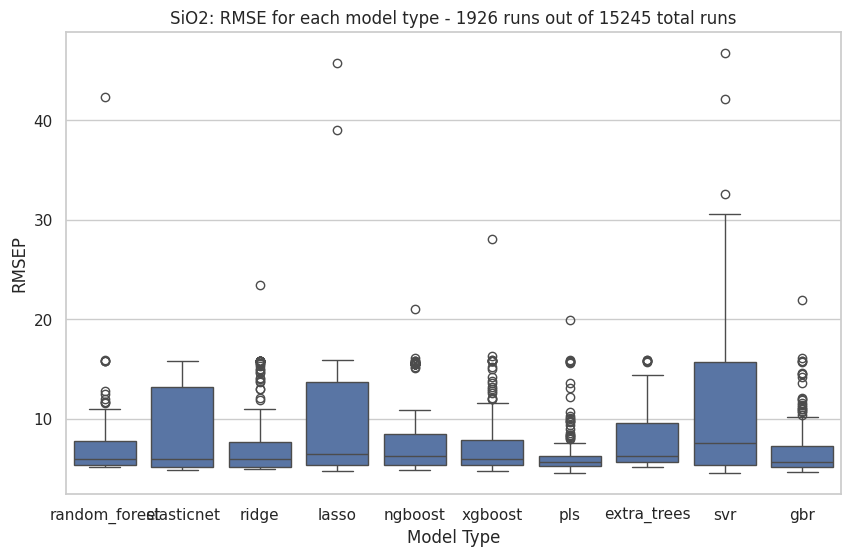

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

total_runs = len(filtered_runs)

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.boxplot(x='params.model_type', y='metrics.rmse_cv', data=filtered_runs_target)
plt.title(f"{analysis_target}: RMSE for each model type - {len(filtered_runs_target)} runs out of {total_runs} total runs")
plt.xlabel("Model Type")
plt.ylabel("RMSEP")
plt.show()


In [130]:
# Find the runs that minimize rmse, rmse_cv, std_dev, and std_dev_cv
optimal_runs = filtered_runs_target.loc[filtered_runs_target[['metrics.rmse', 'metrics.rmse_cv', 'metrics.std_dev', 'metrics.std_dev_cv']].idxmin()]

# Display the optimal runs
optimal_runs[['metrics.rmse', 'metrics.rmse_cv', 'metrics.std_dev', 'metrics.std_dev_cv', 'params.model_type']]


,metrics.rmse,metrics.rmse_cv,metrics.std_dev,metrics.std_dev_cv,params.model_type
1181,3.405844,5.950624,3.380301,5.941987,xgboost
1213,4.084362,4.552021,4.087395,4.551431,pls
1181,3.405844,5.950624,3.380301,5.941987,xgboost
1213,4.084362,4.552021,4.087395,4.551431,pls


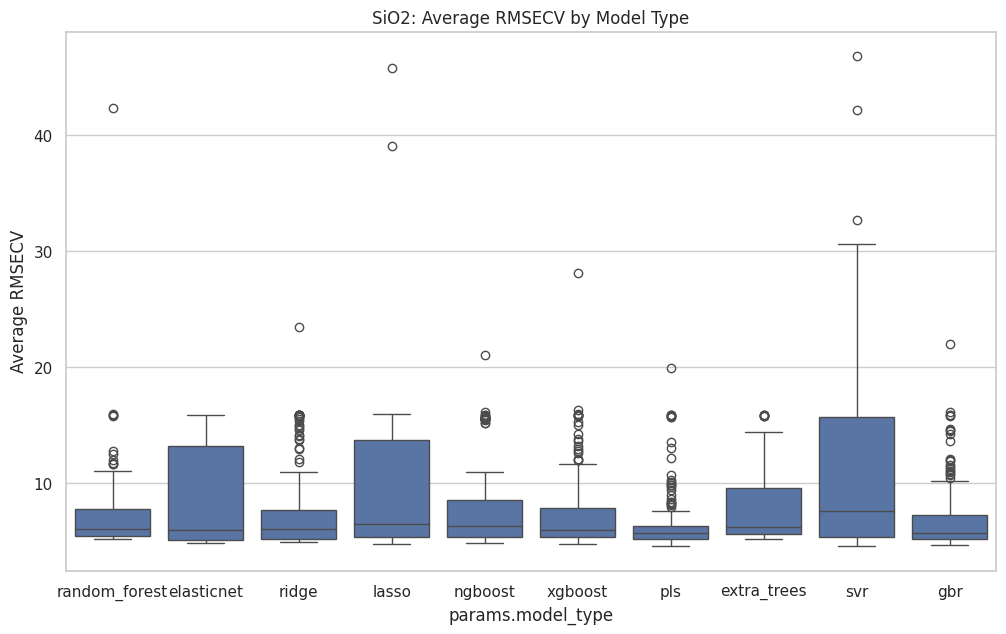

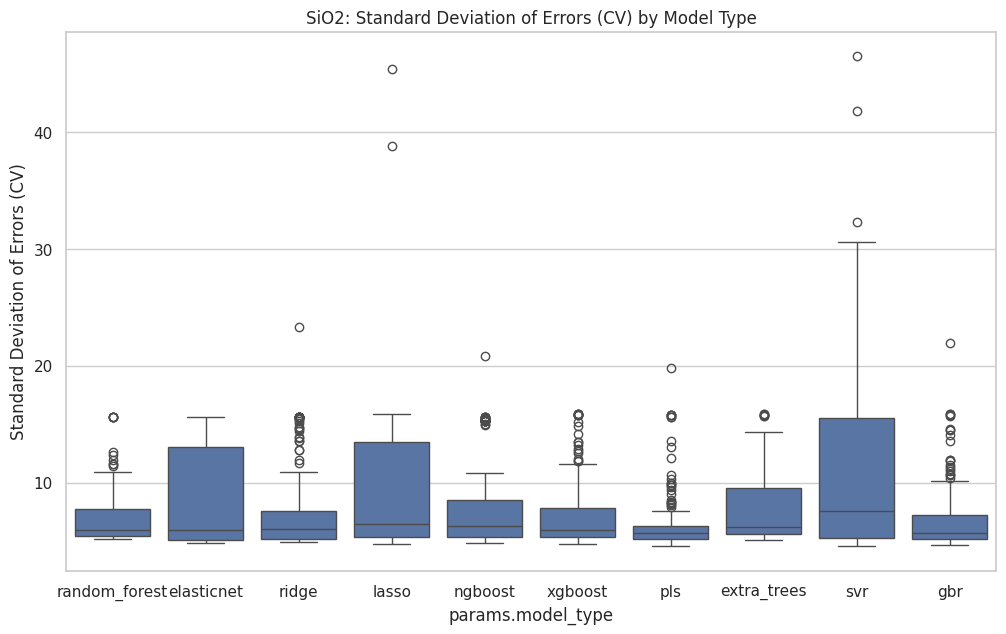

In [131]:
# Setting up visualization style
sns.set(style="whitegrid")

# Plotting RMSE CV
plt.figure(figsize=(12, 7))
sns.boxplot(x='params.model_type', y='metrics.rmse_cv', data=filtered_runs_target)
plt.title(f'{analysis_target}: Average RMSECV by Model Type')
plt.ylabel('Average RMSECV')
plt.show()

# Plotting Standard Deviation of RMSE CV
plt.figure(figsize=(12, 7))
sns.boxplot(x='params.model_type', y='metrics.std_dev_cv', data=filtered_runs_target)
plt.title(f'{analysis_target}: Standard Deviation of Errors (CV) by Model Type')
plt.ylabel('Standard Deviation of Errors (CV)')
plt.show()




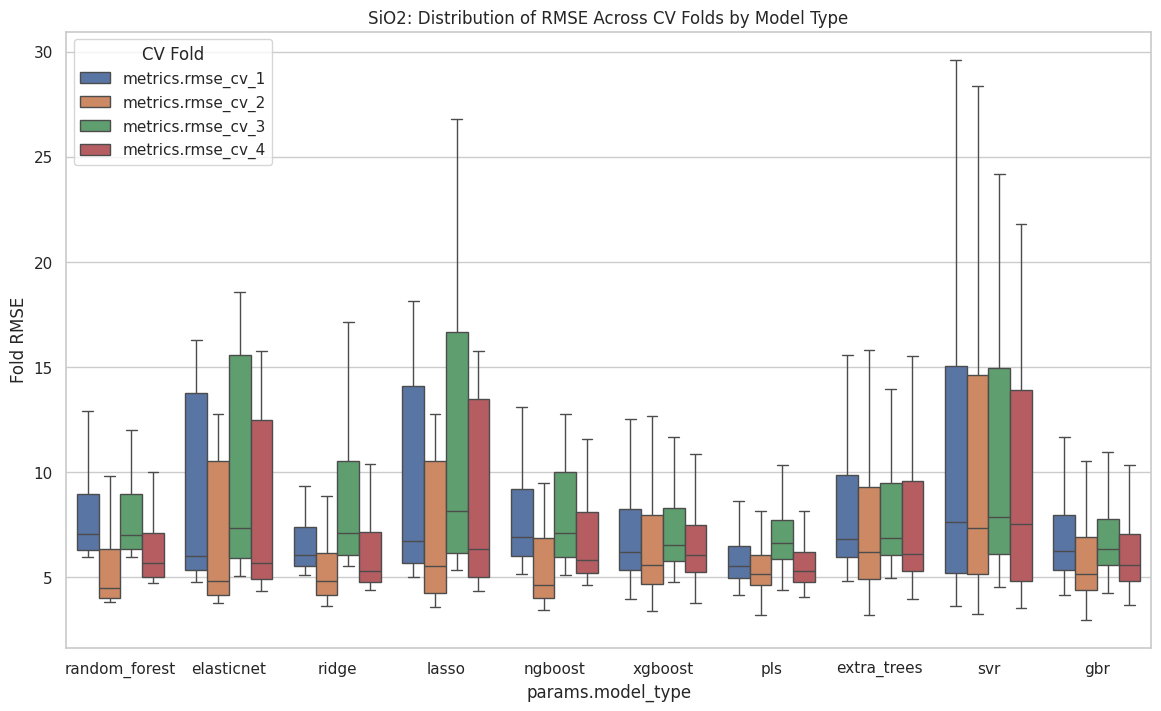

In [132]:
# Prepare a melted DataFrame for seaborn plotting
melted_df = filtered_runs_target.melt(id_vars=['params.model_type'], value_vars=[f'metrics.rmse_cv_{i+1}' for i in range(n_splits)],
                               var_name='CV Fold', value_name='Fold RMSE')

# Plotting without outliers
plt.figure(figsize=(14, 8))
sns.boxplot(x='params.model_type', y='Fold RMSE', hue='CV Fold', data=melted_df, showfliers=False)
plt.title(f'{analysis_target}: Distribution of RMSE Across CV Folds by Model Type')
plt.show()


In [133]:
cv_columns = [
    'metrics.rmse_cv', 'params.model_type', 'params.scaler_type',
    'params.transformer_type', 'params.pca_type'
]
filtered_runs_new = runs[cv_columns]
filtered_runs_new = filtered_runs_new[filtered_runs_new['metrics.rmse_cv'] <= 50]


# Rename columns for clarity
rename_dict = {col: col.split('.')[-1] for col in cv_columns}
filtered_runs_new = filtered_runs_new.rename(columns=rename_dict)

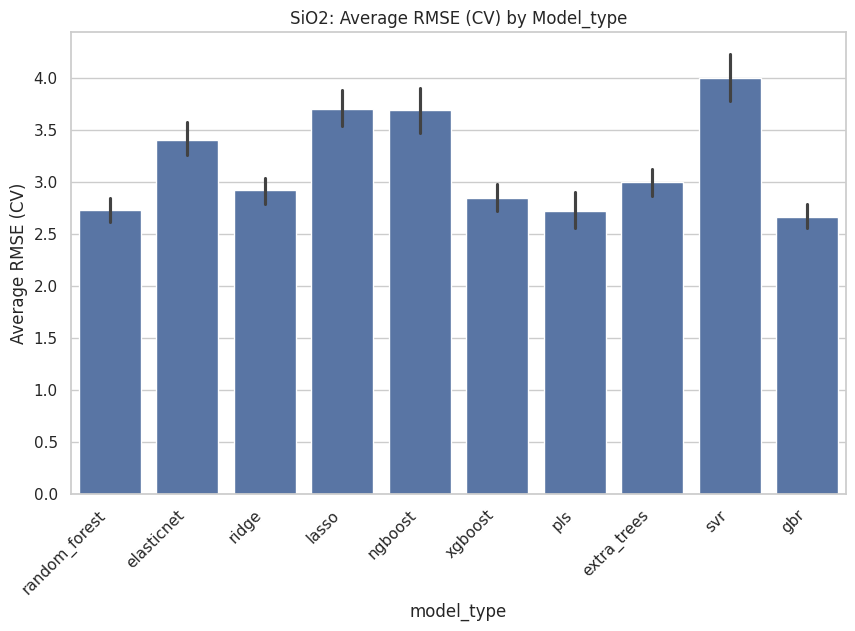

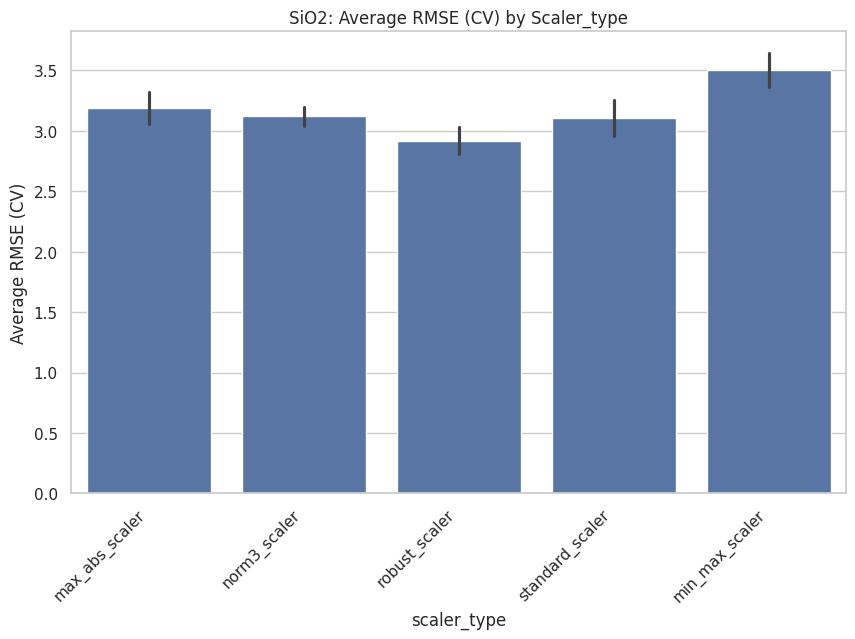

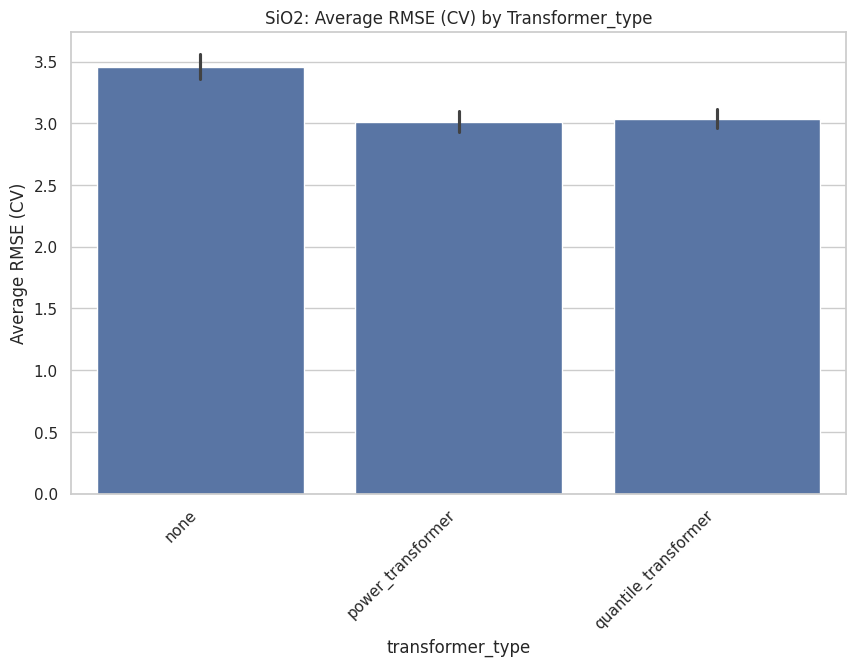

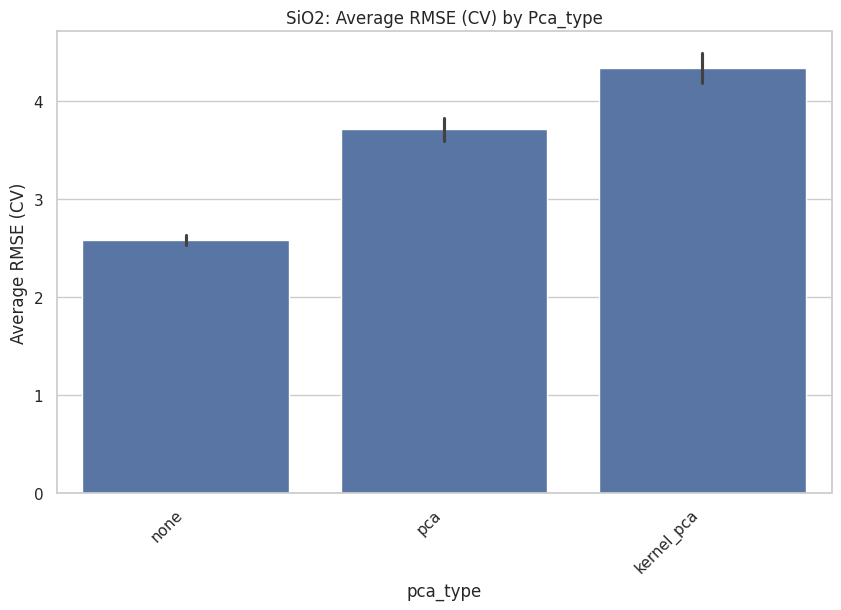

      model_type      scaler_type      transformer_type    pca_type   rmse_cv
329        ridge   min_max_scaler     power_transformer         pca  0.474013
356        ridge  standard_scaler     power_transformer         pca  0.802940
27    elasticnet    robust_scaler                  none  kernel_pca  0.912032
325        ridge   min_max_scaler                  none        none  0.940540
257          pls    robust_scaler     power_transformer         pca  1.091443
354        ridge  standard_scaler     power_transformer  kernel_pca  1.294099
244          pls     norm3_scaler                  none        none  1.320354
76   extra_trees    robust_scaler     power_transformer        none  1.336894
250          pls     norm3_scaler  quantile_transformer        none  1.346358
434      xgboost    robust_scaler                  none         pca  1.427518


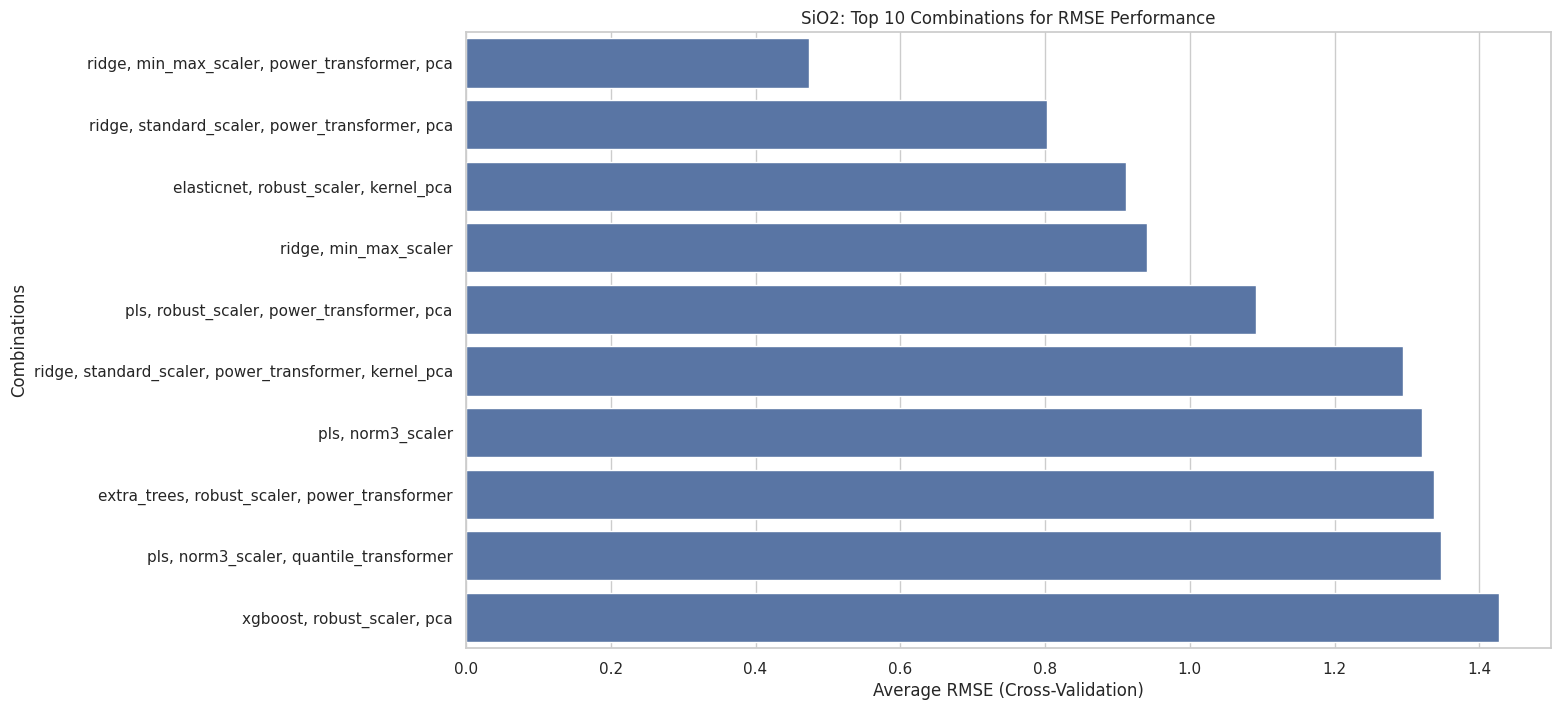

In [134]:
sns.set(style="whitegrid")

# Individual Parameters
for parameter in ['model_type', 'scaler_type', 'transformer_type', 'pca_type']:
    plt.figure(figsize=(10, 6))
    chart = sns.barplot(x=parameter, y='rmse_cv', data=filtered_runs_new)
    chart.set_xticks(range(len(filtered_runs_new[parameter].unique())))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title(f'{analysis_target}: Average RMSE (CV) by {parameter.capitalize()}')
    plt.ylabel('Average RMSE (CV)')
    plt.show()

# Combinations of Parameters
# Considering combinations might result in a lot of categories, focus on the top few based on average RMSE
combination_data = filtered_runs_new.groupby(['model_type', 'scaler_type', 'transformer_type', 'pca_type']).mean()['rmse_cv']
combination_data = combination_data.reset_index().sort_values(by='rmse_cv', ascending=True)

# Display top 10 combinations
print(combination_data.head(10))

# Optionally, visualize these top combinations
plt.figure(figsize=(14, 8))
combination_data_top10 = combination_data[:10]
combination_labels = combination_data_top10.apply(lambda row: ', '.join([str(row[param]) for param in ['model_type', 'scaler_type', 'transformer_type', 'pca_type'] if row[param] != 'none']), axis=1)
sns.barplot(x='rmse_cv', y=combination_labels, data=combination_data_top10, orient='h')
plt.title(f'{analysis_target}: Top 10 Combinations for RMSE Performance')
plt.xlabel('Average RMSE (Cross-Validation)')
plt.ylabel('Combinations')
plt.show()

In [135]:
# Aggregate the data to compute mean and standard deviation of RMSE for each configuration
# Lower RMSE (lower is better) and lower STD RMSE (lower is better for consistency)
aggregated_data = filtered_runs_new.groupby(['model_type', 'scaler_type', 'transformer_type', 'pca_type']).agg({
    'rmse_cv': ['mean', 'std']
}).reset_index()

# Flatten the columns (multi-level index after aggregation)
aggregated_data.columns = ['Model Type', 'Scaler Type', 'Transformer Type', 'PCA Type', 'Mean RMSECV', 'STD RMSECV']

# Sort configurations first by mean RMSE (ascending, lower is better) and then by STD RMSE (ascending, lower is better for consistency)
sorted_data = aggregated_data.sort_values(by=['Mean RMSECV', 'STD RMSECV'], ascending=[True, True])

# Display the top 10 consistently good configurations
print(sorted_data.head(10))

      Model Type      Scaler Type      Transformer Type    PCA Type  \
329        ridge   min_max_scaler     power_transformer         pca   
356        ridge  standard_scaler     power_transformer         pca   
27    elasticnet    robust_scaler                  none  kernel_pca   
325        ridge   min_max_scaler                  none        none   
257          pls    robust_scaler     power_transformer         pca   
354        ridge  standard_scaler     power_transformer  kernel_pca   
244          pls     norm3_scaler                  none        none   
76   extra_trees    robust_scaler     power_transformer        none   
250          pls     norm3_scaler  quantile_transformer        none   
434      xgboost    robust_scaler                  none         pca   

     Mean RMSECV  STD RMSECV  
329     0.474013    0.000185  
356     0.802940         NaN  
27      0.912032    0.446661  
325     0.940540    1.180854  
257     1.091443    1.032141  
354     1.294099    0.117589  
2

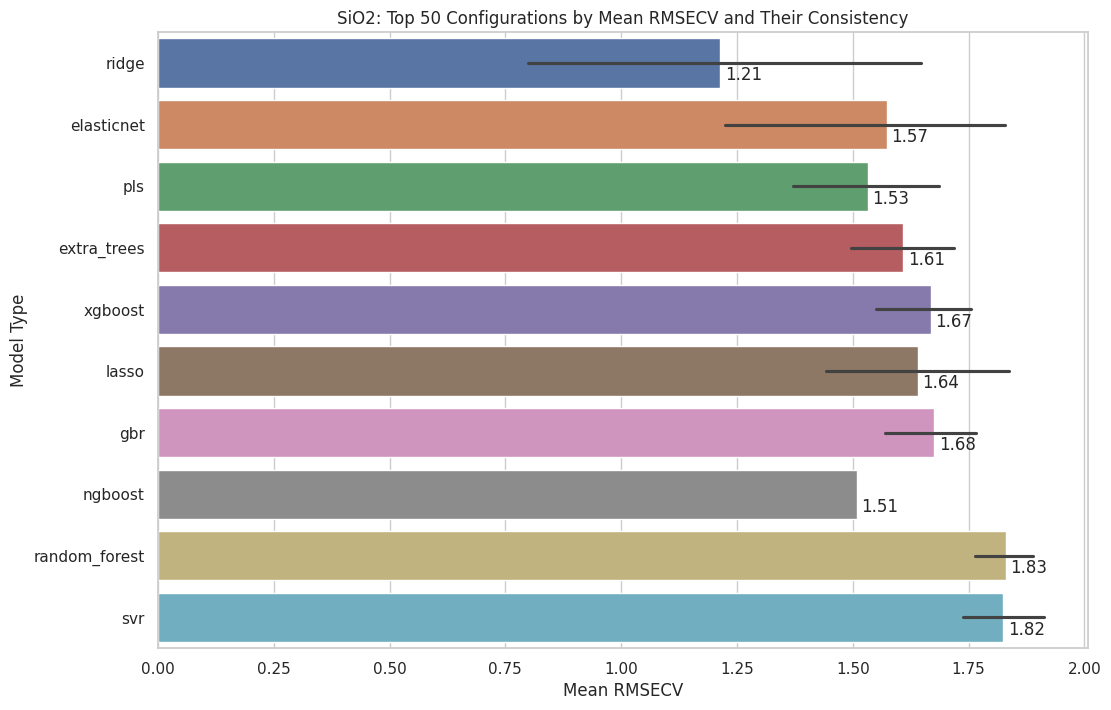

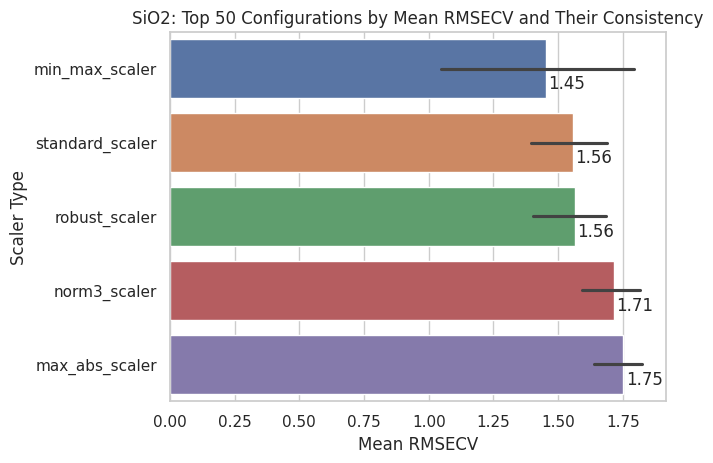

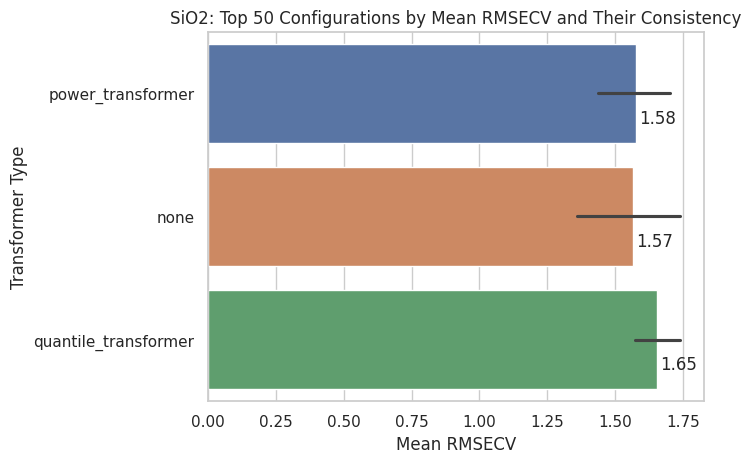

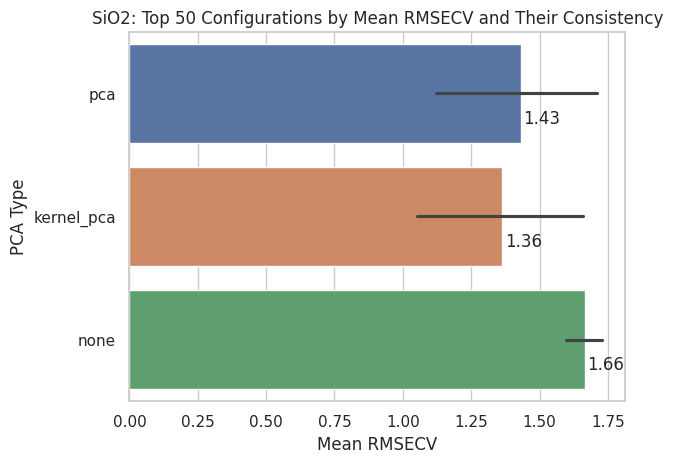

In [136]:
sns.set(style="whitegrid")

# Plotting the top configurations based on Mean RMSE
plt.figure(figsize=(12, 8))
top_n = 50
for parameter in ['Model Type', 'Scaler Type', 'Transformer Type', 'PCA Type']:
    top_configurations = sns.barplot(x='Mean RMSECV', y=parameter, hue=parameter, data=sorted_data.head(top_n), dodge=False)
    plt.title(f'{analysis_target}: Top {top_n} Configurations by Mean RMSECV and Their Consistency')
    plt.xlabel('Mean RMSECV')
    plt.ylabel(parameter)
    # Annotate each bar with the value of Mean RMSE
    for p in top_configurations.patches:
        width = p.get_width()
        plt.text(width + 0.01, p.get_y()+0.2 + p.get_height() / 2, f'{width:.2f}', ha='left', va='center')
    plt.show()


In [137]:
first_row = filtered_runs.sort_values(by="metrics.rmse_cv").iloc[0]
non_none_columns = first_row[first_row.notna()].index.tolist()
first_row[non_none_columns]


Unnamed: 0                                                                    3762
run_id                                            6d1262ee9b194acf898e16a0c3323f0d
experiment_id                                                                  125
status                                                                    FINISHED
artifact_uri                     mlflow-artifacts:/125/6d1262ee9b194acf898e16a0...
start_time                                        2024-05-17 23:18:39.051000+00:00
end_time                                          2024-05-17 23:21:32.431000+00:00
metrics.rmse_cv                                                           0.408701
metrics.rmse_cv_1                                                         0.505297
metrics.rmse_cv_4                                                         0.440556
metrics.rmse                                                              0.397053
metrics.std_dev_cv_4                                                      0.436632
metr